# Introduction
The goal is to help investors to decide where to open a potential new restaurant in Toronto. The data provided will be the income and population per neighborhood. Also, the surrounded restaurants that are considered competitors will be shown. The final project will help the investors to check where to open a profitable new restaurant.

# Data
The income and population per neighborhood in Toronto will be taken from Toronto's Neighbourhood Profiles 2016. This data will be combined with Foursquare API to collect restaurants that are competitors in the same neighborhoods.

Toronto's Neighbourhood Profiles data is publicly available at this website: https://open.toronto.ca/dataset/neighbourhood-profiles

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
!pip install requests
import requests

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

You are using pip version 19.2.3, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Solving environment: ...working... done

# All requested packages already installed.



In [3]:
# Toronto Neighbourhood Profiles 2016 (CSV)
#https://open.toronto.ca/dataset/neighbourhood-profiles

df = pd.read_csv('https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv',encoding='latin1')
df.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No Designat

In [4]:
# Neighborhoods names
Neighborhoods = list(df.columns.values)
Neighbourhoods = Neighborhoods[5:]
print(Neighborhoods)

['Category', 'Topic', 'Data Source', 'Characteristic', 'City of Toronto', 'Agincourt North', 'Agincourt South-Malvern West', 'Alderwood', 'Annex', 'Banbury-Don Mills', 'Bathurst Manor', 'Bay Street Corridor', 'Bayview Village', 'Bayview Woods-Steeles', 'Bedford Park-Nortown', 'Beechborough-Greenbrook', 'Bendale', 'Birchcliffe-Cliffside', 'Black Creek', 'Blake-Jones', 'Briar Hill-Belgravia', 'Bridle Path-Sunnybrook-York Mills', 'Broadview North', 'Brookhaven-Amesbury', 'Cabbagetown-South St. James Town', 'Caledonia-Fairbank', 'Casa Loma', 'Centennial Scarborough', 'Church-Yonge Corridor', 'Clairlea-Birchmount', 'Clanton Park', 'Cliffcrest', 'Corso Italia-Davenport', 'Danforth', 'Danforth East York', 'Don Valley Village', 'Dorset Park', 'Dovercourt-Wallace Emerson-Junction', 'Downsview-Roding-CFB', 'Dufferin Grove', 'East End-Danforth', 'Edenbridge-Humber Valley', 'Eglinton East', 'Elms-Old Rexdale', 'Englemount-Lawrence', 'Eringate-Centennial-West Deane', 'Etobicoke West Mall', 'Fleming

In [5]:
#Population and average income per neighborhood
toronto_df = pd.DataFrame(index=Neighborhoods, columns=["Population","Income"])
toronto_df.index.name = 'Neighborhoods'
for index, row in toronto_df.iterrows():
    toronto_df.at[index, 'Population'] = df[index][2]
    toronto_df.at[index, 'Income'] = df[index][2264] 
Neighborhoods = [x.replace("St. ","St.") for x in Neighborhoods]
idx = Neighborhoods.index('Mimico (includes Humber Bay Shores)')
Neighborhoods[idx] = 'Mimico'
idx = Neighborhoods.index('Weston-Pelham Park')
Neighborhoods[idx] = 'Weston-Pellam Park'
toronto_df.index = Neighborhoods
toronto_df = toronto_df.iloc[5:]
toronto_df['Population'] = toronto_df['Population'].apply(lambda x: int(x.replace(',','')))
toronto_df['Income'] = toronto_df['Income'].apply(lambda x: int(x.replace(',','')))
toronto_df = toronto_df.sort_values('Population', ascending=False)
toronto_df.head()

,Population,Income
Waterfront Communities-The Island,65913,70600
Woburn,53485,30878
Willowdale East,50434,45326
Rouge,46496,39556
L'Amoreaux,43993,31826


In [6]:
# Toronto Neighbourhood Profiles 2016 (CSV)
#https://open.toronto.ca/dataset/neighbourhood-profiles

locations = pd.read_csv('Neighbourhoods.csv',encoding='latin1')[['AREA_NAME','LONGITUDE','LATITUDE']]
locations.head()

,AREA_NAME,LONGITUDE,LATITUDE
0,Wychwood (94),-79.425515,43.676919
1,Yonge-Eglinton (100),-79.403590,43.704689
2,Yonge-St.Clair (97),-79.397871,43.687859
3,York University Heights (27),-79.488883,43.765736
4,Yorkdale-Glen Park (31),-79.457108,43.714672


In [7]:
locations.AREA_NAME = locations.AREA_NAME.apply(lambda x: x[:x.find('(')].rstrip())

In [8]:
locations.columns = ["Neighborhoods", "Longitude", "Latitude"]
locations.Neighborhoods = locations.Neighborhoods.apply(lambda x: x.replace("St. ","St."))
locations = locations.set_index('Neighborhoods')
locations.head()

,Longitude,Latitude
Neighborhoods,,
Wychwood,-79.425515,43.676919
Yonge-Eglinton,-79.403590,43.704689
Yonge-St.Clair,-79.397871,43.687859
York University Heights,-79.488883,43.765736
Yorkdale-Glen Park,-79.457108,43.714672


In [9]:
toronto_df = toronto_df.join(locations).iloc[5:]

In [12]:
#Add the population weightage for each neighbourhood.
total_population = toronto_df['Population'].sum()
total_income = toronto_df['Income'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
toronto_df['Population Score'] = toronto_df['Population']/total_population*100
toronto_df['Income Score'] = toronto_df['Income']/total_income*100
toronto_df.head(10)

,Population,Income,Longitude,Latitude,Population Score,Income Score
Islington-City Centre West,43965,52787,-79.543317,43.633463,1.779059,0.702272
Malvern,43794,29573,-79.222517,43.803658,1.772140,0.393436
Dovercourt-Wallace Emerson-Junction,36625,39740,-79.438541,43.665677,1.482044,0.528696
Downsview-Roding-CFB,35052,34168,-79.490497,43.733292,1.418392,0.454567
Parkwoods-Donalda,34805,42516,-79.330180,43.755033,1.408397,0.565628
Mimico,33964,54438,-79.500137,43.615924,1.374365,0.724237
West Humber-Clairville,33312,31771,-79.596356,43.716180,1.347982,0.422678
Mount Olive-Silverstone-Jamestown,32954,26548,-79.587259,43.746868,1.333495,0.353191
Church-Yonge Corridor,31340,53583,-79.379017,43.659649,1.268184,0.712862
Niagara,31180,70623,-79.412420,43.636681,1.261710,0.939560


In [13]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

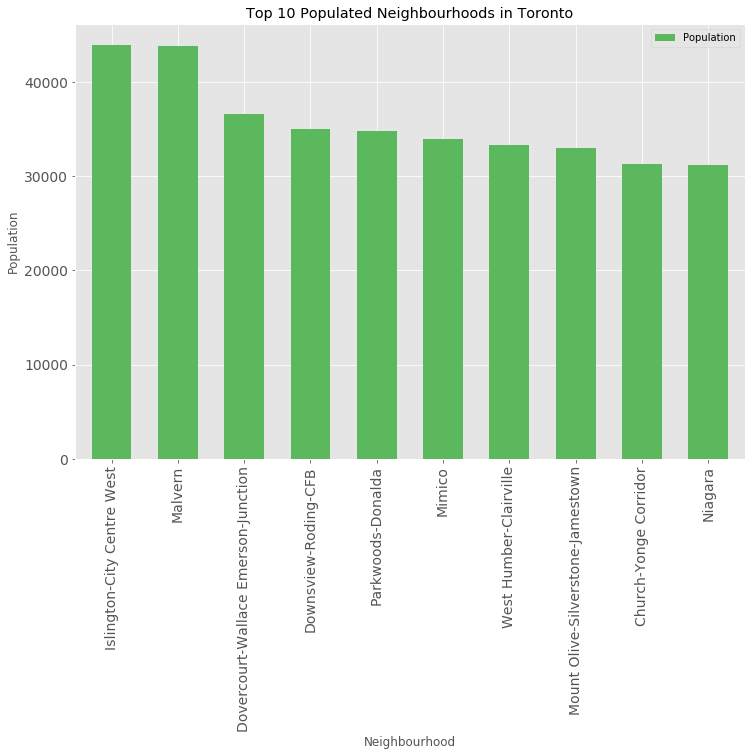

In [14]:
population_chart = toronto_df[['Population']].copy()
top_chart = population_chart.head(10)

# plot data
color = '#5cb85c'
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=color)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

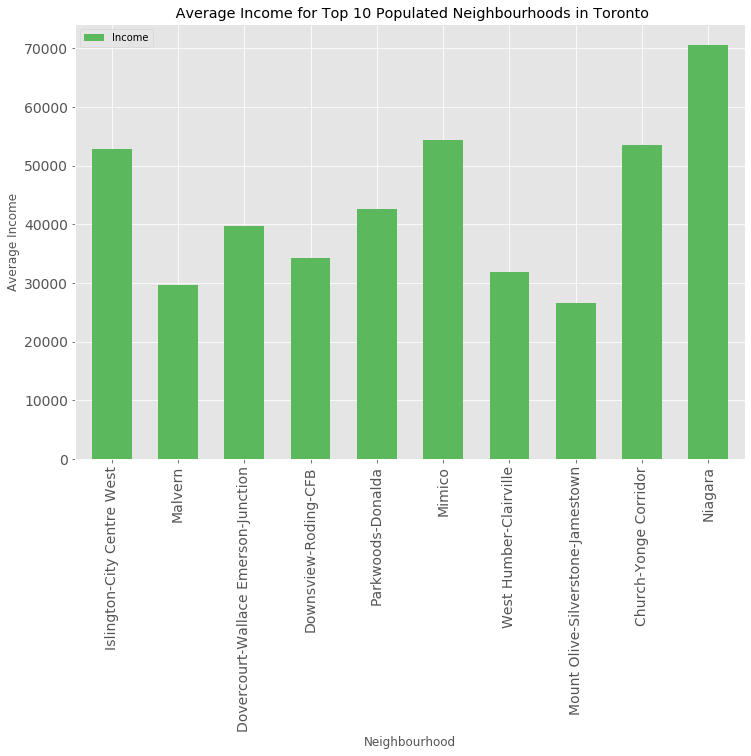

In [15]:
Income_chart = toronto_df[['Income']].copy()
top_chart = Income_chart.head(10)

# plot data
color = '#5cb85c'
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=color)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Average Income') # add y-label to the plot
plt.title(' Average Income for Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

In [16]:
CLIENT_ID = 'IFQ424CPMQT4IKW42R2ZXSMVZSB1YR0CGJI5XPNUDFDUKZ1E' # your Foursquare ID
CLIENT_SECRET = 'G13PERG0DPUUE0TI5CR3JF2H1GFRV1V3YBH2BNU04GEWX4FR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IFQ424CPMQT4IKW42R2ZXSMVZSB1YR0CGJI5XPNUDFDUKZ1E
CLIENT_SECRET:G13PERG0DPUUE0TI5CR3JF2H1GFRV1V3YBH2BNU04GEWX4FR


In [17]:
#Create a general function to get the venue data
def getNearbyRestaurants(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId=4d4b7105d754a06374d81259&ll={},{}&radius={}&limit=50'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']['location']['lng'], venue['venue']['categories'][0]['name']) for venue in results])

    nearby_restaurant = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_restaurant.columns = ['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Restaurant', 'Restaurant Latitude', 'Restaurant Longitude', 'Restaurant Category']  
    return(nearby_restaurant)

In [20]:
toronto_restaurants_df = getNearbyRestaurants(names=toronto_df.index.tolist(),latitudes=toronto_df['Latitude'],longitudes=toronto_df['Longitude'])

In [21]:
toronto_restaurants_df.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,Islington-City Centre West,43.633463,-79.543317,Taste of Thailand Cuisine,43.635928,-79.540785,Thai Restaurant
1,Islington-City Centre West,43.633463,-79.543317,Mekong River Restaurant,43.632643,-79.544184,Vietnamese Restaurant
2,Islington-City Centre West,43.633463,-79.543317,Kebab 49,43.635943,-79.540422,Turkish Restaurant
3,Islington-City Centre West,43.633463,-79.543317,Swiss Chalet,43.632057,-79.544213,Restaurant
4,Islington-City Centre West,43.633463,-79.543317,Harvey's,43.632549,-79.543757,Fast Food Restaurant


In [22]:
counts = toronto_restaurants_df.groupby('Neighborhoods').size().reset_index(name='counts')
counts = counts.set_index('Neighborhoods')

In [23]:
toronto_df = toronto_df.join(counts)
toronto_df = toronto_df.fillna(0)

In [25]:
print('{} uniques categories.'.format(len(toronto_restaurants_df['Restaurant Category'].unique())))

94 uniques categories.


## Analyzing each neighborhood

In [30]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_restaurants_df[['Restaurant Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = toronto_restaurants_df['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhoods,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Islington-City Centre West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Islington-City Centre West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Islington-City Centre West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Islington-City Centre West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Islington-City Centre West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# group rows by neighborhood taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhoods').mean().reset_index()
toronto_grouped.head()

,Neighborhoods,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt North,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.090909,0.090909
1,Agincourt South-Malvern West,0.0,0.043478,0.0,0.0,0.086957,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.347826,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.043478,0.043478,0.0,0.000000,0.0,0.0,0.043478,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,Alderwood,0.0,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.2,0.000000,0.0,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Annex,0.0,0.058824,0.0,0.0,0.058824,0.058824,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.176471,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.058824,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.058824,0.0,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.058824,0.0,0.176471,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.000000,0.000000
4,Banbury-Don Mills,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.200000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00

In [32]:
restcounts = toronto_df['counts'].sum()

# the more restaurants on a neighbourhood, the higher score will get
toronto_df['Restaurants Score'] = toronto_df['counts']/restcounts*100

In [34]:
# considering this to be a fair weightage for the three scores' parameters
weight = 1/3

# calculate the total score
toronto_df['Total Score'] = (toronto_df['Population Score']*weight) + (toronto_df['Income Score']*weight) + (toronto_df['Restaurants Score']*weight)

# sort the dataframe based on the descending total score
toronto_df = toronto_df.sort_values('Total Score', ascending=False)

In [35]:
toronto_df.head()

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score
Church-Yonge Corridor,31340,53583,-79.379017,43.659649,1.268184,0.712862,50.0,4.042037,2.007694
Mount Pleasant West,29658,57039,-79.393360,43.704435,1.200121,0.758840,50.0,4.042037,2.000333
Bay Street Corridor,25797,56526,-79.385721,43.657511,1.043885,0.752015,50.0,4.042037,1.945979
Yonge-St.Clair,12528,114174,-79.397871,43.687859,0.506950,1.518957,44.0,3.556993,1.860967
Kensington-Chinatown,17945,37422,-79.397240,43.653554,0.726151,0.497858,47.0,3.799515,1.674508


## Visualizing the Neighborhoods in Toronto according to income and population

In [36]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: ...working... done

# All requested packages already installed.



In [37]:
# Segmenting and clustering in Toronto.
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = toronto_df
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

C:\Users\20190958\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """


In [38]:
# Reset the index of dataframe
toronto = toronto_df.reset_index()
toronto.rename(columns={ toronto.columns[0]: "AREA_NAME" }, inplace = True)

In [64]:
toronto_neighborhood_geo = 'toronto_crs84.geojson'

# Create map
toronto_map = folium.Map(
       location=[latitude,longitude],
       zoom_start=11)

# Use json file  TEST based on class
toronto_map.choropleth(
       geo_data=toronto_neighborhood_geo,
       data=toronto,
       columns=['AREA_NAME','Income'],
       key_on='feature.properties.AREA_NAME',
       fill_color='YlOrRd',
       fill_opacity='0.7',
       line_opacity='0.2',
       legend_name='Crime Rate in San Francisco, by Neighborhood')
# add markers to map
for lat, lng, neighborhood, score, competitors in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df.index,toronto_df['Population'],toronto_df['counts']):
    label = '{} with {} population and {} restaurants'.format(neighborhood, score, int(competitors))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=score/2000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
# display the map
toronto_map

The above map made it easy to decide wehere to have new restaurant based on demand (population and income) and supply (available restuarnts). So for example, Bridle Path York Mills has very high average income but the population is very low so we can say having average demand. The supply in that neighborhood is also very low as it has only 5 restaurants so maybe it can be a potential new restaurant place with average to high prices menu.

## Clustering the neighbourhoods using K-Clustering.

In [47]:
# set number of clusters
kclusters = 5
# Remove unneeded features for the kmeans clustering
toronto_clustering = toronto_df.reset_index().drop('index', 1)
toronto_clustering = toronto_df.drop('Latitude', 1)
toronto_clustering = toronto_df.drop('Longitude', 1)
# run k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)
# add clustering labels
toronto_df['Cluster Label'] = kmeans.labels_

toronto_df.head()

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Church-Yonge Corridor,31340,53583,-79.379017,43.659649,1.268184,0.712862,50.0,4.042037,2.007694,1
Mount Pleasant West,29658,57039,-79.393360,43.704435,1.200121,0.758840,50.0,4.042037,2.000333,1
Bay Street Corridor,25797,56526,-79.385721,43.657511,1.043885,0.752015,50.0,4.042037,1.945979,1
Yonge-St.Clair,12528,114174,-79.397871,43.687859,0.506950,1.518957,44.0,3.556993,1.860967,2
Kensington-Chinatown,17945,37422,-79.397240,43.653554,0.726151,0.497858,47.0,3.799515,1.674508,4


## Draw the Clusters Map

In [53]:
import matplotlib.colors as colors

clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# clusters color array
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df.reset_index()['index'], toronto_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)
       
clusters_map

## Evaluation

In [54]:
# Top 10 neighbourhoods based on total score
toronto_df.sort_values('Total Score', ascending=False).head()

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Church-Yonge Corridor,31340,53583,-79.379017,43.659649,1.268184,0.712862,50.0,4.042037,2.007694,1
Mount Pleasant West,29658,57039,-79.393360,43.704435,1.200121,0.758840,50.0,4.042037,2.000333,1
Bay Street Corridor,25797,56526,-79.385721,43.657511,1.043885,0.752015,50.0,4.042037,1.945979,1
Yonge-St.Clair,12528,114174,-79.397871,43.687859,0.506950,1.518957,44.0,3.556993,1.860967,2
Kensington-Chinatown,17945,37422,-79.397240,43.653554,0.726151,0.497858,47.0,3.799515,1.674508,4


In [67]:
# Cluster 1 
toronto_df.loc[toronto_df['Cluster Label'] == 0].sort_values('Population Score', ascending=False).head(4)

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Rosedale-Moore Park,20923,207903,-79.379669,43.682820,0.846657,2.765917,1.0,0.080841,1.231138,0
Lawrence Park South,15179,169203,-79.406039,43.717212,0.614224,2.251057,4.0,0.323363,1.062881,0
Casa Loma,10968,165047,-79.408007,43.681852,0.443824,2.195766,4.0,0.323363,0.987651,0
Forest Hill South,10732,204521,-79.414318,43.694526,0.434274,2.720923,2.0,0.161681,1.105626,0


In [68]:
# Cluster 2
toronto_df.loc[toronto_df['Cluster Label'] == 1].sort_values('Population Score', ascending=False).head(4)

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Islington-City Centre West,43965,52787,-79.543317,43.633463,1.779059,0.702272,13.0,1.050930,1.177420,1
Mimico,33964,54438,-79.500137,43.615924,1.374365,0.724237,5.0,0.404204,0.834269,1
Church-Yonge Corridor,31340,53583,-79.379017,43.659649,1.268184,0.712862,50.0,4.042037,2.007694,1
Niagara,31180,70623,-79.412420,43.636681,1.261710,0.939560,15.0,1.212611,1.137960,1


In [69]:
# Cluster 3
toronto_df.loc[toronto_df['Cluster Label'] == 2].sort_values('Population Score', ascending=False).head(4)

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Annex,30526,112766,-79.404001,43.671585,1.235245,1.500226,17.0,1.374293,1.369921,2
Bedford Park-Nortown,23236,123077,-79.420227,43.731486,0.940253,1.637402,21.0,1.697656,1.425103,2
The Beaches,21567,92580,-79.299601,43.671050,0.872716,1.231673,30.0,2.425222,1.509871,2
St.Andrew-Windfields,17812,100516,-79.379037,43.756246,0.720769,1.337253,0.0,0.000000,0.686007,2


In [70]:
# Cluster 4
toronto_df.loc[toronto_df['Cluster Label'] == 3].sort_values('Population Score', ascending=False).head(4)

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Bridle Path-Sunnybrook-York Mills,9266,308010,-79.378904,43.731013,0.374952,4.097729,5.0,0.404204,1.625628,3


In [71]:
# Cluster 5
toronto_df.loc[toronto_df['Cluster Label'] == 4].sort_values('Population Score', ascending=False).head(4)

,Population,Income,Longitude,Latitude,Population Score,Income Score,counts,Restaurants Score,Total Score,Cluster Label
Malvern,43794,29573,-79.222517,43.803658,1.772140,0.393436,4.0,0.323363,0.829646,4
Dovercourt-Wallace Emerson-Junction,36625,39740,-79.438541,43.665677,1.482044,0.528696,6.0,0.485044,0.831928,4
Downsview-Roding-CFB,35052,34168,-79.490497,43.733292,1.418392,0.454567,0.0,0.000000,0.624320,4
Parkwoods-Donalda,34805,42516,-79.330180,43.755033,1.408397,0.565628,2.0,0.161681,0.711902,4


## Discussion

Based on the map of population and income, the neighborhoods in the middle of Toronto were good choices for the new restaurants as they have high income average and good population.

Based on clustering, the first and fifth clusters ( 0 and 4) had the best potential places as the first one has very low supply (low restaurants number) with average demand (population) and the fifth one has very high demand (high population score) with low restaurants number (low supply).
As we have the average income, it is recommended that the new restaurants focus on high prices menu for the first cluster and low prices menu for the fifth one.

## Conclusion

We have concluded that the best potential new restaurant place in Toronto will be either first or fifth cluster as there is average to high demand with low supply (low competitors).